# Transfer learning и ResNet
 В этот раз мы продолжим работать с изображениями с помощью нейронных сетей. В этот раз мы обсудим, как адаптировать уже существующие обученные модели для своих задач

План:
- ResNet
- transfer learning и fine-tuning
- Визуализация модели
- Torchmetrics, scheduler, ???

In [1]:
import glob
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchmetrics
import matplotlib
import tqdm
from torch import nn
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Normalize, Resize, ToTensor, PILToTensor, ConvertImageDtype
from torchvision.transforms import v2
%matplotlib inline
warnings.filterwarnings("ignore")

device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [2]:
DATA_PATH = "../../datasets/one-piece-classification/splitted/train/"
TEST_DATA_PATH = "../../datasets/one-piece-classification/splitted/test/"

# TODO: change path to yours!

In [3]:
dataset = ImageFolder(
    DATA_PATH,
    transform=Compose(
        [
            Resize((224, 224)),
            ToTensor(),
            Normalize((0.5, 0.5, 0.5), (1, 1, 1)),
        ]
    ),
)
train_set, val_set = torch.utils.data.random_split(
    dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))]
)

train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=16, shuffle=False)

*Задание*: выведите случайный элемент датасета

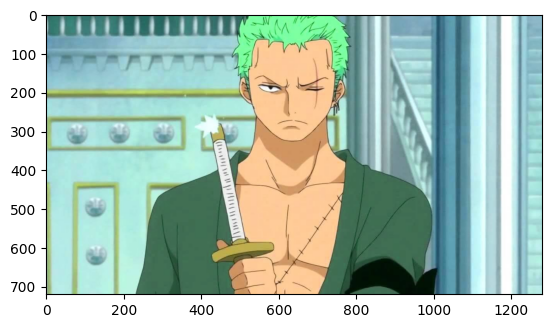

In [4]:
#Ace, Akainu, Brook, Chopper, Crocodile, Franky, Jinbei, Kurohige, Law, Luffy, Mihawk, Nami, Rayleigh, Robin, Sanji, Shanks, Usopp, Zoro

folder= np.random.choice(["Ace", "Akainu", "Brook", "Chopper", "Crocodile", "Franky", "Jinbei", "Kurohige", "Law", "Luffy", "Mihawk", "Nami", "Rayleigh", "Robin", "Sanji", "Shanks", "Usopp", "Zoro"])
file = np.random.choice(glob.glob(f'{DATA_PATH}/{folder}/*.*'))
img = matplotlib.image.imread(file)
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5..0.48039216].


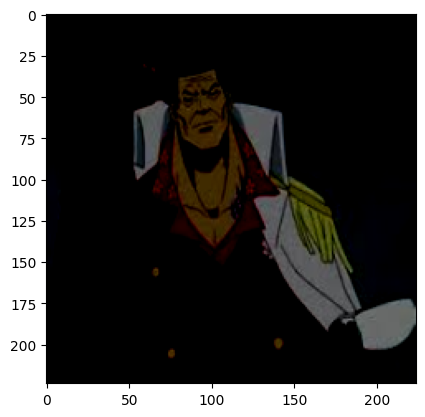

In [5]:
# выведите 352 семпл
#plt.imshow(dataset[352][0].permute(1, 2, 0))

plt.imshow(dataset[np.random.randint(0, 350)][0].permute(1, 2, 0))

Тут мы сталкиваемся с двумя проблемами сразу:
- датасет очень маленький, и собирать его руками достаточно сложно
- если мы попробуем обучить какую-то модель с нуля, это может занять очень много времени

К тому же, наши картинки еще довольно похожи на стандартные изображения. Поэтому можно попытаться как-то перенести уже полученные знания какой-то крутой модели на свою задачу.
Чаще всего для этого ипользуется файн-тюнинг.

Идея у него проста: модель, когда-то обученная на большом датасете, уже умеет выделять какие-то хорошие признаки из входных данных, поэтому мы можем взять ее веса и немного поменять их, чтобы она лучше понимала новую задачу.


## ResNet
Исследователи заметили, что когда речь идет о сверточных нейронных сетях, чем модель глубже, тем лучше. Это имеет смысл, потому что их гибкость в адаптации к любому пространству увеличивается с увеличением числа параметров). Однако было замечено, что начиная с некоторй глубины, точность перестает увеличиваться, а наоборот, начинает падать.
*Вопрос:* с чем связано это явление?

Так появилось семейство ResNet. Идея проста: еслт модель может предсказать $f(x)$, то может предсказать и $f(x) - x$.
Это очень полезно, так как позволяет улучшить обучаемость моделей. (Чем?)
![alt_text](../../additional_materials/images/resnet.png)

В модели это реализовано следующим образом: к выходу слоя можно добавить его же вход (что распространяется и на более длинные связи).

Обычный блок выглядит примерно следующим образом:

Input: x

[Conv 3x3]
[Batch Normalization]
[Activation (e.g., ReLU)]
[Conv 3x3]
[Batch Normalization]

Add: x + F(x) (Output from the above layers)
[Activation (e.g., ReLU)]


Глубокие варианты используют не двухслойные блоки, но также и bottleneck блоки, которые состоят из трех сверточных слоев следующего вида:

[Conv 1x1]
[BN + ReLU]
[Conv 3x3]
[BN + ReLU]
[Conv 1x1]
[BN]

*Вопрос*: Почему используются блоки 3x3?
*Вопрос 2*: А почему по два таких слоя в блоке, а не один?


В библиотеке torchvision имплементировано не только большое множество моделей (всевозможные ResNet'ы, Inception, VGG, AlexNet, DenseNet, ResNext, WideResNet, MobileNet...), но и загружены чекпоинты обучения этих моделей на ImageNet.

In [6]:
from torchvision.models import resnet18

In [7]:
model = resnet18(pretrained=True)

In [8]:
# выведите модель
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Transfer learning
В задаче transfer learning'a последний слой нейросети заменяется на линейный с нужным числом выходов, а веса остальных слоёв "замораживаются".
Иногда делают полный файнтюн, тогда основные веса тоже обучаются, но в таком случае нужно задавать очень маленькие значения скорости обучения, чтобы не забыть то, что модель выучила раньше

Задание: определите, сколько классов в нашем датасете

In [9]:
# YOUR CODE
print(f'{len(dataset.class_to_idx)} classes')
dataset.class_to_idx

18 classes


{'Ace': 0,
 'Akainu': 1,
 'Brook': 2,
 'Chopper': 3,
 'Crocodile': 4,
 'Franky': 5,
 'Jinbei': 6,
 'Kurohige': 7,
 'Law': 8,
 'Luffy': 9,
 'Mihawk': 10,
 'Nami': 11,
 'Rayleigh': 12,
 'Robin': 13,
 'Sanji': 14,
 'Shanks': 15,
 'Usopp': 16,
 'Zoro': 17}

In [10]:
{"0": "Ace", "1": "Akainu", "2": "Brook", "3": "Chopper", "4": "Crocodile", "5": "Franky", "6": "Jinbei", "7": "Kurohige", "8": "Law", "9": "Luffy", "10": "Mihawk", "11": "Nami", "12": "Rayleigh", "13": "Robin", "14": "Sanji", "15": "Shanks", "16": "Usopp", "17": "Zoro"}

{'0': 'Ace',
 '1': 'Akainu',
 '2': 'Brook',
 '3': 'Chopper',
 '4': 'Crocodile',
 '5': 'Franky',
 '6': 'Jinbei',
 '7': 'Kurohige',
 '8': 'Law',
 '9': 'Luffy',
 '10': 'Mihawk',
 '11': 'Nami',
 '12': 'Rayleigh',
 '13': 'Robin',
 '14': 'Sanji',
 '15': 'Shanks',
 '16': 'Usopp',
 '17': 'Zoro'}

Теперь научимся загружать веса нашей модели, а также переделывать ее под свои нужды.

In [11]:
def get_model(
        pretrained: bool = True, num_out_classes: int=10
):
    if pretrained:
        model = resnet18(pretrained=True)
        # freeze parameters of original model
        for param in model.parameters():
            param.requires_grad = False
        model.fc = nn.Linear(model.fc.in_features, num_out_classes)
    else:
        # <YOUR CODE>
        model = resnet18(pretrained=False)
        model.fc = nn.Linear(model.fc.in_features, num_out_classes)
    return model


Проверим нашу функцию

In [12]:
model = get_model(pretrained=True, num_out_classes=5)

In [13]:
# Проверьте, задан ли градиент у какого-нибудь слоя из тела модели (это все, что не голова)
next(model.layer1[0].conv1.parameters())[0].requires_grad

False

In [14]:
loss = torch.nn.CrossEntropyLoss() # задайте подходящий лосс

В этом ноутбуке мы рассмотрим еще очень полезную библиотеку, которая поможет нам считать метрики качества.

In [15]:
import torchmetrics
from torchmetrics import MetricCollection
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassF1Score
import torchmetrics.classification

'''
acc = torchmetrics.Accuracy(
    task="multiclass",
    num_classes=18
)

F1score = torchmetrics.F1Score(
    task="multiclass",
    num_classes=18
)
'''
num_classes = 18
metrics = MetricCollection({
    "acc":    MulticlassAccuracy(num_classes),
#    "prec":   MulticlassPrecision(num_classes),
#    "recall": MulticlassRecall(num_classes),
    "F1":     MulticlassF1Score(num_classes)
})

*Задание*: добавьте метрики Precision, recall.
*Задание 2*: сравните метрики с reduction=micro, macro. Ответьте, в чем разница и в каких ситуациях та или иная настройка лучше отражает качество предсказаний.

Вспомним рутину: напишем обучающий цикл. Заполните функциии в нужных местах.

In [16]:
def train_epoch(
    model: nn.Module,
    data_loader: torch.utils.data.DataLoader,
    criterion: nn.Module,
    metric: torchmetrics.MetricCollection,
    optimizer: torch.optim.Optimizer,
    return_losses=False,
):
    model = model.train()
    total_loss = 0
    num_batches = 0
    all_losses = []
    with tqdm.tqdm(total=len(data_loader)) as prbar:
        for inputs, targets in data_loader:
            # train step: preds, loss, optimization, etc
            # <YOUR CODE>
            optimizer.zero_grad()
            preds = model(inputs)
            loss = criterion(preds, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            # update description for tqdm
            metrics_dict = metric(preds, targets)
            metrics_str = f"Loss: {round(loss.item(), 4)} "
            for k, v in metrics_dict.items():
                metrics_str += f"{k}: {round(float(v), 4)} "

            prbar.set_description(
                metrics_str
            )
            prbar.update(1)
            total_loss += loss.item()
            num_batches += 1
            all_losses.append(loss.detach().item())
    total_metrics_dict = metric.compute()
    #metrics = {"train_loss": total_loss / num_batches, "train_accuracy": metrics_dict}
    total_metrics_dict["train_loss"] = total_loss
    if return_losses:
        return total_metrics_dict, all_losses
    else:
        return total_metrics_dict


def validate(
        model,
        data_loader,
        criterion,
        metric: torchmetrics.MetricCollection,
        device="cuda:0"):
    model = model.eval()
    total_loss = 0
    num_batches = 0
    with tqdm.tqdm(total=len(data_loader)) as prbar:
        for inputs, targets in data_loader:
            with torch.no_grad():
                # <YOUR CODE>
                preds = model(inputs)
                loss = criterion(preds, targets)
                total_loss += loss.item()
                
                metrics_dict = metric(preds, targets)
            
            metrics_str = f"Loss: {round(loss.item(), 4)} "
            for k, v in metrics_dict.items():
                metrics_str += f"{k}: {round(float(v), 4)} "
            prbar.set_description(metrics_str)
            prbar.update(1)

            total_loss += loss.item()
            num_batches += 1
    total_metrics_dict = metric.compute()
    #metrics = {"val_loss": total_loss / num_batches} # <YOUR CODE> total_metrics_dict
    total_metrics_dict["val_loss"] = total_loss
    return total_metrics_dict

Иногда удобно сохранять данные в определенном формате. Один из возможных вариантов - namedtuple. Он похволяет как сохранять порядок элементов, так и использовать более понятную индексацию

In [17]:
from collections import namedtuple

LossInfo = namedtuple(
    "LossInfo", ["full_train_losses", "train_epoch_losses",
                    "epoch_train_acc_losses", "epoch_train_f1_losses",
                 "epoch_val_loss_losses", "epoch_val_acc_losses", "epoch_val_f1_losses"]
)

EPOCHS = 10
LR = 0.001

In [18]:
def train(
    model,
    epochs,
    train_data_loader,
    validation_data_loader,
    criterion,
    metrics,
    optimizer,
    scheduler=None,
    device="cuda:0",
):
    all_train_losses = []
    epoch_train_losses = []
    epoch_train_acc_losses = []
    epoch_train_f1_losses = []

    epoch_val_acc_losses = []
    epoch_val_f1_losses = []
    epoch_val_loss_losses = []
    

    for epoch in range(epochs):
        # construct iterators
        train_iterator = iter(train_data_loader)
        validation_iterator = iter(validation_data_loader)
        # train step
        print(f"Train Epoch: {epoch}")

        model.train()
        
        train_metrics_collection = metrics.clone(prefix='t_')
        valid_metrics_collection = metrics.clone(prefix='v_')

        train_metrics, one_epoch_train_losses = train_epoch(
            model=model,
            data_loader=train_iterator,
            criterion=criterion,
            metric=train_metrics_collection,
            optimizer=optimizer,
            return_losses=True,
        )

        # save train losses
        all_train_losses.append(one_epoch_train_losses)
        epoch_train_losses.append(train_metrics["train_loss"])
        epoch_train_acc_losses.append(train_metrics["t_acc"])
        epoch_train_f1_losses.append(train_metrics["t_F1"])

        # eval step
        # call function validation epoch and
        # save eval losses
        model.eval()
        print(f"Validation Epoch: {epoch}")

        test_metrics = validate(
            model=model,
            data_loader=validation_iterator,
            criterion=criterion,
            metric=valid_metrics_collection,
        )

        print(test_metrics)

        epoch_val_acc_losses.append(test_metrics["v_acc"])
        epoch_val_f1_losses.append(test_metrics["v_F1"])
        epoch_val_loss_losses.append(test_metrics["val_loss"])



        if scheduler:
            scheduler.step()
    return LossInfo(all_train_losses, epoch_train_losses, epoch_train_acc_losses, epoch_train_f1_losses,
                    epoch_val_loss_losses, epoch_val_acc_losses, epoch_val_f1_losses)

*Задание*: запустите обучение с использованием transfer learning и без него. В каком случае точность получилась выше?


In [19]:
model = get_model(pretrained=True, num_out_classes=18).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR) # задайте оптимизатор

In [ ]:
model.to(device)
_ = train(
    model=model,
    epochs=10,
    train_data_loader=train_dataloader,
    validation_data_loader=val_dataloader,
    criterion=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=device,
)

Train Epoch: 0


Loss: 2.4091 t_F1: 0.2 t_acc: 0.2 :  46%|████▌     | 67/146 [00:16<00:20,  3.81it/s]      

# Подгрузим данные из test, прогоним через модель

In [ ]:
import os
from PIL import Image
import pandas as pd
def read_image(path):
    #path = Path(path)
    image = Image.open(path)
    if image.mode != 'RGB':
        image = image.convert('RGB')
    image_array = np.array(image)
    image_array = np.transpose(image_array, (2, 0, 1))
    image_tensor = torch.from_numpy(image_array)
    return image_tensor

def create_csv(model, path, sample_path = None):
    #transform=v2.Compose(
    #    [
    #        v2.Resize((128, 128)),
    #        v2.ToImage(), v2.ToDtype(torch.float32, scale=True),
    #        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    #    ])
    transform=Compose(
        [
            v2.Resize((224, 224)),
            v2.ToImage(), v2.ToDtype(torch.float32, scale=True),
            #ToTensor(),
            v2.Normalize((0.5, 0.5, 0.5), (1, 1, 1)),
        ])
    #data = pd.read_csv(sample_path)
    l = []
    model.to(device)
    for name in os.listdir(path):
        img = read_image(f"{path}/{name}")
        img = transform(img)
        img = img.unsqueeze(0)
        img = img.to(device)
        with torch.no_grad():
            model.eval()
            preds = model(img)
            preds = preds.to("cpu")
            l.append((os.path.splitext(name)[0],int(preds.argmax(1).squeeze(0))))

    out = pd.DataFrame(data = l, columns = ["id","label"])
    out.to_csv("subm.csv",index=False)

In [ ]:
create_csv(model=model, path=TEST_DATA_PATH)

In [ ]:

# You should not pass)
asodoasod 

# Визуализация сети

Каждый слой в CNN изучает фильтры возрастающей сложности. На первых слоях выучиваются простые признаки, такие как края и углы. Средние слои обнаруживают части объектов — что касается лиц, они могут научиться реагировать на глаза и носы. Последние слои имеют более высокоуровневые представления: они учатся распознавать объекты целиком, в различных формах и положениях.

Мы попробуем проверить, так ли это, с помощью GradientExplainer, который использует ожидаемые градиенты для оценки входов в разные части модели. В целом, они аппроксимируют значения SHAP.

Возьмем по 50 семплов для подсчёта ожидаемых градиентов и посмотрим на признаки первых слоёв ResNet.

In [ ]:
model.eval()
data = dataset[0]

In [ ]:
dataset.classes

In [ ]:
import shap
to_explain = torch.stack([dataset[0][0], dataset[123][0]], dim=0)
e = shap.GradientExplainer((model, model.layer1[0].conv2), to_explain)
# receive shap_values
shap_values, indexes = e.shap_values(
    to_explain, ranked_outputs=4, nsamples=50
)

# plot the explanations
#shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]


In [ ]:
shap_values.shape

In [ ]:
shap.image_plot(shap_values[0], to_explain.detach().cpu().numpy())

In [ ]:
shap.image_plot(shap_values[1], to_explain.detach().cpu().numpy())

Повторите для второго слоя

In [ ]:
# YOUR CODE
to_explain = torch.stack([dataset[0][0], dataset[123][0]], dim=0).to(device)
e = shap.GradientExplainer((model, model.layer2[0].conv2), to_explain)
# receive shap_values
shap_values, indexes = e.shap_values(
    to_explain, ranked_outputs=4, nsamples=50
)

In [ ]:
# YOUR CODE
shap.image_plot(shap_values[0], to_explain.detach().cpu().numpy())

Повторите для 4 слоя)

In [ ]:
# YOUR CODE
to_explain = torch.stack([dataset[0][0], dataset[123][0]], dim=0).to(device)
e = shap.GradientExplainer((model, model.layer4[0].conv2), to_explain)
# receive shap_values
shap_values, indexes = e.shap_values(
    to_explain, ranked_outputs=4, nsamples=50
)
shap.image_plot(shap_values[0], to_explain.detach().cpu().numpy())

Но это не единственный способ заглянуть внутрь модели. Простейший вариант - оценить значения активаций на внутренних слоях. Можно было бы вывести веса, но они, к сожалению, не слишком интерпретируемы. Активации же показывают силу реакции конкретного фильтра.

Далее попробуем посмотреть на значения активаций при при проходе через изображение. В этом нам помогут хуки - эти функции позволяют получить доступ к состоянию между слоями (как входа, так и выхода слоя)
для визуализации, трансфер-лернинга, дебага модели итд.

In [ ]:
activations = {}

# Function to create a hook
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# For example, let's hook into the first convolutional layer and the first block of layer1
model.conv1.register_forward_hook(get_activation('conv1'))
model.layer1[0].register_forward_hook(get_activation('layer1_block1'))


In [ ]:
# Function to visualize feature maps
def visualize_feature_maps(activation, title, num_cols=8):
    num_feature_maps = activation.shape[0]
    num_rows = num_feature_maps // num_cols
    plt.figure(figsize=(num_cols, num_rows))
    for i in range(num_feature_maps):

        if i >= num_cols * num_rows:
            break
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(activation[i].cpu().numpy(), cmap='coolwarm')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

#

Выведите значения активаций

In [ ]:
# Perform a forward pass
with torch.no_grad():
    # прогоните модель для первого элемента датасета
    output = model(dataset[0][0].unsqueeze(0).to(device)) #your code


In [ ]:
for name, activation in activations.items():
    # For convolutional layers, activation shape is (batch_size, num_channels, H, W)
    act = activation[0]
    act = act - act.min() # Почему нужно нормализовать?
    act = act / act.max()
    visualize_feature_maps(act, title=f'Activations from {name}')

попробуйте добавить хук и для 4 слоя. Какие значения у активаций? Похоже ли это на то, что мы видели для shap values?

In [ ]:
activations = {}

# Function to create a hook
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# For example, let's hook into the first convolutional layer and the first block of layer1
model.conv1.register_forward_hook(get_activation('conv1'))
model.layer4[0].register_forward_hook(get_activation('layer_block1'))

In [ ]:
# Perform a forward pass
with torch.no_grad():
    # прогоните модель для первого элемента датасета
    output = model(dataset[0][0].unsqueeze(0).to(device))

In [ ]:
for name, activation in activations.items():
    # For convolutional layers, activation shape is (batch_size, num_channels, H, W)
    act = activation[0]
    act = act - act.min() # Почему нужно нормализовать?
    act = act / act.max()
    visualize_feature_maps(act, title=f'Activations from {name}')